In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

In [17]:
from scipy import stats
from scipy.stats import uniform
import statsmodels.api as sm


# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

In [18]:
data = pd.read_csv('../raw_data/dataset.csv',sep=';')
data = data.copy()
data.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [19]:
data.shape

(99976, 43)

## 1. feature selection

In [20]:
# # removing column "uuid" from the dataset
# data_id = data['uuid']
# data.drop(['uuid'], axis=1, inplace=True)
# # setting target and removing the "default" from dataset
# target = data['default']
# data.drop(['default'], axis=1, inplace=True)
# # isna and isnull were not recognizing "nan" 
# data = data.replace('nan', np.NaN)
###
# removing the missing values of the target and these raws from the dataset
###
# removing coulumn "uuid" from the dataset
# data_id = data['uuid']
# #_ = data.reset_index()
# #data = _.drop(['uuid'], axis=1)
# data.drop(['uuid'], axis=1, inplace=True)
# # setting target and removing the "default" from dataset
# target = data['default'].dropna()
# data.dropna(subset=['default'], axis=0, inplace=True)
# data.drop(['default'], axis=1, inplace=True)
# # isna and isnull were not recognizing "nan" 
# data = data.replace('nan', np.NaN)


In [21]:
 # converting these columns to "object" type
list_float_to_obj = ["worst_status_active_inv", "account_status","account_worst_status_0_3m",
                     "account_worst_status_12_24m", "account_worst_status_3_6m", "account_worst_status_6_12m",
                     "status_last_archived_0_24m", "status_2nd_last_archived_0_24m","status_3rd_last_archived_0_24m",
                     "status_max_archived_0_6_months","status_max_archived_0_12_months","status_max_archived_0_24_months",
                     "has_paid"]

_ = [data.__setitem__(feature, data[feature].astype("object")) for feature in list_float_to_obj]

As one can see we do have features with a high numbers of unique values


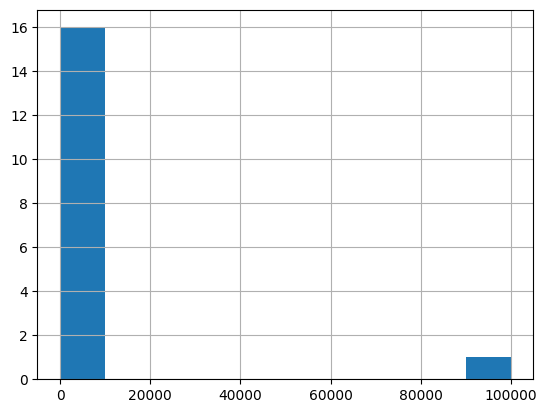

In [22]:
# The above code have got the following  warning message: 
    # UserWarning: Persisting input arguments took 2.21s to run.
    # If this happens often in your code, it can cause performance problems 
    # (results will be correct in all cases). 
    # The reason for this is probably some large input arguments for a wrapped
    #  function (e.g. large strings).
    # THIS IS A JOBLIB ISSUE.
# To tackle this issue we're foreseeing the possibility of removing from the dataset all categoric features with 7 unique values or more.
feat_categorical_nunique = data.select_dtypes(include='object').nunique()
feat_categorical_nunique.hist();
print("As one can see we do have features with a high numbers of unique values")
# categorical features 
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique > 7].index)

In [23]:
feat_categorical_small
# data['merchant_category'].unique()
# len(data['merchant_group'].unique())
# I am considering to remove
    ## 1. "merchant_category"
    ## 2. "name_in_email"
    # I will check on this on next model by looking at feature_importance_ attribute

['uuid', 'merchant_category', 'merchant_group', 'name_in_email']

#### 1st first apporach

In [24]:
# removing coulumn "uuid" from the dataset
data_id = data['uuid']
#_ = data.reset_index()
#data = _.drop(['uuid'], axis=1)
data.drop(['uuid'], axis=1, inplace=True)
# setting target and removing the "default" from dataset
#target = data['default'].dropna()
data.dropna(subset=['default'], axis=0, inplace=True)
#data.drop(['default'], axis=1, inplace=True)
# isna and isnull were not recognizing "nan" 
data = data.replace('nan', np.NaN)

In [25]:
column_names 

array(['name_in_email_F', 'name_in_email_F+L', 'name_in_email_F1+L',
       'name_in_email_Initials', 'name_in_email_L', 'name_in_email_L1+F',
       'name_in_email_Nick', 'name_in_email_no_match',
       'merchant_group_Automotive Products',
       'merchant_group_Children Products',
       'merchant_group_Clothing & Shoes', 'merchant_group_Electronics',
       'merchant_group_Entertainment', 'merchant_group_Erotic Materials',
       'merchant_group_Food & Beverage', 'merchant_group_Health & Beauty',
       'merchant_group_Home & Garden',
       'merchant_group_Intangible products',
       'merchant_group_Jewelry & Accessories',
       'merchant_group_Leisure, Sport & Hobby',
       'merchant_category_Adult Shoes & Clothing',
       'merchant_category_Automotive Parts & Accessories',
       'merchant_category_Bags & Wallets',
       'merchant_category_Body & Hair Care',
       'merchant_category_Books & Magazines',
       'merchant_category_Car electronics',
       'merchant_category_

In [26]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

feature_ohe = OneHotEncoder(sparse_output=False) # Instantiate One hot encoder
encoded_features = feature_ohe.fit_transform(data[['name_in_email', 'merchant_group', 'merchant_category']])

# Create a dataframe with the encoded features
column_names = feature_ohe.get_feature_names_out()
encoded_df = pd.DataFrame(encoded_features, columns=column_names)

# Concatenate the original dataframe with the encoded dataframe
data = pd.concat([data, encoded_df], axis=1)

# Drop the original columns
data.drop(columns=['name_in_email', 'merchant_group', 'merchant_category'], inplace=True)

data.head()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,...,merchant_category_Sex toys,merchant_category_Sports gear & Outdoor,merchant_category_Tobacco,merchant_category_Tools & Home improvement,merchant_category_Travel services,merchant_category_Underwear,merchant_category_Video Games & Related accessories,merchant_category_Wheels & Tires,"merchant_category_Wine, Beer & Liquor",merchant_category_Youthful Shoes & Clothing
0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# defeining data_GLM with the target default
data_GLM = pd.DataFrame()
data_GLM['default'] = data['default']
data_GLM[column_names] = data[column_names]
data_GLM

,default,name_in_email_F,name_in_email_F+L,name_in_email_F1+L,name_in_email_Initials,name_in_email_L,name_in_email_L1+F,name_in_email_Nick,name_in_email_no_match,merchant_group_Automotive Products,...,merchant_category_Sex toys,merchant_category_Sports gear & Outdoor,merchant_category_Tobacco,merchant_category_Tools & Home improvement,merchant_category_Travel services,merchant_category_Underwear,merchant_category_Video Games & Related accessories,merchant_category_Wheels & Tires,"merchant_category_Wine, Beer & Liquor",merchant_category_Youthful Shoes & Clothing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89973,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
89974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Testing

#### Chi-squared for association
> #### let's the first feature "merchant_category_Youthful Shoes & Clothing"
> #### alpha = 0.05 - the critical value 
> #### H_0: there is no association the chosen feature and the other ones

In [28]:
_ = data_GLM[data_GLM["default"]==1].groupby("merchant_category_Youthful Shoes & Clothing")["default"].count().value_counts().keys()
default_list = np.array(_)
default_list
_ = data_GLM[data_GLM["default"]==0].groupby("merchant_category_Youthful Shoes & Clothing")["default"].count().value_counts().keys()
non_default_list = np.array(_)
non_default_list

array([78427, 10261])

In [29]:
_ = data_GLM[data_GLM["default"]==0].groupby("merchant_category_Youthful Shoes & Clothing")["default"].count().value_counts().keys()
non_default_list = np.array(_)
non_default_list

array([78427, 10261])

In [30]:
# total numbers of customers in this category
data_GLM[data_GLM["merchant_category_Youthful Shoes & Clothing"] == 1]["merchant_category_Youthful Shoes & Clothing"].count()

10524

In [31]:
# total numbers of customers not in this category
data_GLM[data_GLM["merchant_category_Youthful Shoes & Clothing"] == 0]["merchant_category_Youthful Shoes & Clothing"].count()

79452

In [32]:
# gouping the default cases by the category under consideration
default_counts = data_GLM[data_GLM["default"]==1].groupby("merchant_category_Youthful Shoes & Clothing")["default"].count().value_counts().keys()
# gouping the non default cases by the category under consideration
non_default_counts = data_GLM[data_GLM["default"]==0].groupby("merchant_category_Youthful Shoes & Clothing")["default"].count().value_counts().keys()
#creating the dataframe
test =pd.DataFrame({"default":default_counts,
                     "non default":non_default_counts},
                  index=['Youthful Shoes & Clothing (0)', 'Youthful Shoes & Clothing (1)'])
test

,default,non default
Youthful Shoes & Clothing (0),1025,78427
Youthful Shoes & Clothing (1),263,10261


In [33]:
table = []
table.append(default_counts)
table.append(non_default_counts)
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(table)

In [34]:
print("The p-value is esqual to {}".format(round(p,2)))
print("we can rej the null hypothesis, no association")
print("let's apply to all")

The p-value is esqual to 0.0
we can rej the null hypothesis, no association
let's apply to all


In [35]:
# setting all the features to apply the test
features_test = data_GLM.iloc[:,1:].columns

In [36]:
# setting all the possible combinations
def getCombinations(seq):
    combinations = list()
    for i in range(0,len(seq)):
            combinations.append([seq[i], "default" ])
    return pd.DataFrame(combinations, columns = ['features', "compared_with"])

In [37]:
# creating the dataframe with the features to test against the default variable
all_combinations = getCombinations(features_test)

In [38]:
confusion_matrix = []
for index in range(0, len(all_combinations)):
    confusion_matrix.append(pd.crosstab(data_GLM[all_combinations['features'][index]], data_GLM[all_combinations['compared_with'][index]]))

In [39]:
import scipy.stats as ss

In [40]:
all_combinations['p_value'] = [round(ss.chi2_contingency(confusion_matrix[index])[1],3) for index in range(len(all_combinations))]
all_combinations

,features,compared_with,p_value
0,name_in_email_F,default,0.111
1,name_in_email_F+L,default,0.000
2,name_in_email_F1+L,default,0.706
3,name_in_email_Initials,default,0.788
4,name_in_email_L,default,0.010
...,...,...,...
72,merchant_category_Underwear,default,0.678
73,merchant_category_Video Games & Related access...,default,0.000
74,merchant_category_Wheels & Tires,default,0.001
75,"merchant_category_Wine, Beer & Liquor",default,1.000


In [41]:
all_combinations['dependence'] = all_combinations['p_value'].apply(lambda x: 'Dependent' if x < 0.05 else 'Independent') 
all_combinations

,features,compared_with,p_value,dependence
0,name_in_email_F,default,0.111,Independent
1,name_in_email_F+L,default,0.000,Dependent
2,name_in_email_F1+L,default,0.706,Independent
3,name_in_email_Initials,default,0.788,Independent
4,name_in_email_L,default,0.010,Dependent
...,...,...,...,...
72,merchant_category_Underwear,default,0.678,Independent
73,merchant_category_Video Games & Related access...,default,0.000,Dependent
74,merchant_category_Wheels & Tires,default,0.001,Dependent
75,"merchant_category_Wine, Beer & Liquor",default,1.000,Independent


In [42]:
# p_values above the alpha of 5%
all_combinations['p_value'][all_combinations['p_value']>0.05].count()

50

In [43]:
all_combinations['null rej'] = all_combinations['p_value'].apply(lambda x: 'No' if x > 0.05 else 'Yes')

In [44]:
# most of our features are correlated 
# individually these categories matters to explain the target
all_combinations[all_combinations['null rej'] == 'Yes']


,features,compared_with,p_value,dependence,null rej
1,name_in_email_F+L,default,0.000,Dependent,Yes
4,name_in_email_L,default,0.010,Dependent,Yes
5,name_in_email_L1+F,default,0.018,Dependent,Yes
6,name_in_email_Nick,default,0.000,Dependent,Yes
7,name_in_email_no_match,default,0.000,Dependent,Yes
10,merchant_group_Clothing & Shoes,default,0.000,Dependent,Yes
11,merchant_group_Electronics,default,0.000,Dependent,Yes
12,merchant_group_Entertainment,default,0.000,Dependent,Yes
13,merchant_group_Erotic Materials,default,0.000,Dependent,Yes
14,merchant_group_Food & Beverage,default,0.000,Dependent,Yes


In [45]:
np.array(all_combinations[all_combinations['null rej'] == 'Yes']['features'])


array(['name_in_email_F+L', 'name_in_email_L', 'name_in_email_L1+F',
       'name_in_email_Nick', 'name_in_email_no_match',
       'merchant_group_Clothing & Shoes', 'merchant_group_Electronics',
       'merchant_group_Entertainment', 'merchant_group_Erotic Materials',
       'merchant_group_Food & Beverage', 'merchant_group_Home & Garden',
       'merchant_group_Intangible products',
       'merchant_group_Leisure, Sport & Hobby',
       'merchant_category_Books & Magazines',
       'merchant_category_Cosmetics', 'merchant_category_Dating services',
       'merchant_category_Diversified electronics',
       'merchant_category_Diversified entertainment',
       'merchant_category_Diversified erotic material',
       'merchant_category_Food & Beverage',
       'merchant_category_Plants & Flowers',
       'merchant_category_Prints & Photos', 'merchant_category_Sex toys',
       'merchant_category_Tobacco',
       'merchant_category_Video Games & Related accessories',
       'merchant_cat

In [46]:
# I have to change column "dependence. I believe is the other way around